## Problem Statement:

Insightin Health partners with Medicare insurance companies to create better member journeys. An issue one of our clients suffers is the significant loss of members in recent years. Before finding out the best action, our first task is to identify members who are likely to terminate their insurance plan.


The objectives are to:<br>  
1) explore within each parameter, and examine for statistical correlations among different parameters and review the distribution patterns; <br> 
2) develop a risk score that can be applied to all the existing members showing how likely each member is going to disenroll from a plan; <br> 
3) evaluate method & further discussions.

## 1. Import data

In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('DataScience-HomeworkData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76995 entries, 0 to 76994
Data columns (total 17 columns):
MEMBER_ID             76995 non-null object
LOB                   76995 non-null object
Voluntary             25206 non-null object
churned               76995 non-null int64
Tenure                76995 non-null int64
hadGap.               76995 non-null int64
Age                   76995 non-null int64
SDOHScore             76995 non-null float64
conditionScore        76995 non-null float64
substanceScore        76995 non-null float64
physFrailtyScore      76995 non-null float64
mentalFrailtyScore    76995 non-null float64
EDCost                66365 non-null float64
EDCount               66365 non-null float64
IPCost                66365 non-null float64
IPCount               66365 non-null float64
State                 76995 non-null object
dtypes: float64(9), int64(4), object(4)
memory usage: 10.0+ MB


In [3]:
df.head()

,MEMBER_ID,LOB,Voluntary,churned,Tenure,hadGap.,Age,SDOHScore,conditionScore,substanceScore,physFrailtyScore,mentalFrailtyScore,EDCost,EDCount,IPCost,IPCount,State
0,7ea90bb64201ddaf463eb9419ad990d9,LOB2,NaN,0,49,0,59,0.018738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PA
1,6319ce06253302493c1fe5d57d57aba7,LOB1,NaN,0,49,0,80,0.012270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PA
2,e7c98ad14a283b1bb751dd73b76f1ef9,LOB1,NaN,0,49,0,45,0.000435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PA
3,6189fb5bf21454cb7c01f15cb1bb78ec,LOB4,NaN,0,49,0,25,0.033174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NC
4,8793004f217e16c695b043fa78b9c74b,LOB5,NaN,0,49,0,66,0.405166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OH


## 2. Exploratory data analysis

In [4]:
df.describe()

,churned,Tenure,hadGap.,Age,SDOHScore,conditionScore,substanceScore,physFrailtyScore,mentalFrailtyScore,EDCost,EDCount,IPCost,IPCount
count,76995.000000,76995.000000,76995.000000,76995.000000,76995.000000,76995.00000,76995.000000,76995.000000,76995.000000,66365.000000,66365.000000,6.636500e+04,66365.000000
mean,0.327372,1429.131268,0.115852,60.320008,0.264275,0.18384,0.077503,0.077058,0.224086,1050.521080,1.688194,4.700686e+03,0.524388
std,0.469257,1378.630014,0.320049,14.588613,0.516757,0.21631,0.154429,0.104734,0.249983,2881.194445,4.093950,1.759468e+04,1.575237
min,0.000000,0.000000,0.000000,15.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,335.000000,0.000000,52.000000,0.003828,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,0.000000,931.000000,0.000000,62.000000,0.033894,0.15000,0.000000,0.000000,0.000000,122.210000,1.000000,0.000000e+00,0.000000
75%,1.000000,2026.000000,0.000000,70.000000,0.293096,0.30000,0.000000,0.111111,0.500000,1068.440000,2.000000,0.000000e+00,0.000000
max,1.000000,4552.000000,1.000000,107.000000,8.115451,1.00000,1.000000,0.777778,1.000000,267123.170000,287.000000,1.381901e+06,80.000000


In [5]:
df.LOB.unique()

array(['LOB2', 'LOB1', 'LOB4', 'LOB5', 'LOB3', 'LOB8', 'LOB7', 'LOB6'],
      dtype=object)

In [6]:
df.Voluntary.unique()

array([nan, 'Voluntary', 'Involuntary - Medicare / Other',
       'Involuntary - SNP'], dtype=object)

In [24]:
churnperc=df.churned[df.churned==1].count()/df.churned.count()*100
print('The percentage of disenrolled customers is',"{0:.2f}".format(churnperc) ,'%.')

The percentage of disenrolled customers is 32.74 %.


There are null values in the Voluntary column, which are likely empty cells for existing customers that have not disenrolled the program. The voluntary column gives us some info about the percentage of voluntary disenrollment vs non-voluntary disenrollment. However, we can not use this column for churn prediction as this column is a descriptive column for churn and contains the churn information within the column. Before we remove the voluntary column, let's check how many churns are voluntary.

### 2.1  How many churns are voluntary?

In [7]:
churned=df[df.churned==1] ## select the churned customers

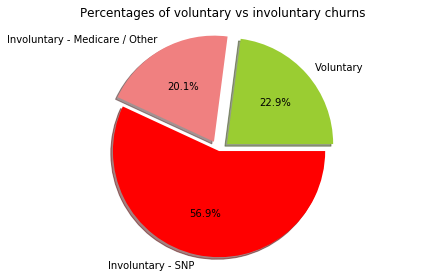

In [8]:
labels = ['Voluntary', 'Involuntary - Medicare / Other','Involuntary - SNP']
churncount = churned.groupby('Voluntary').count()
colors = ['yellowgreen', 'lightcoral','red']

explode = (0.1, 0.1, 0)  
plt.pie(churncount['churned'], labels=labels,explode=explode,shadow=True, colors=colors,autopct='%.1f%%')
plt.axis('equal')
plt.title("Percentages of voluntary vs involuntary churns")
plt.tight_layout()
plt.show()

In [9]:
df=df.drop(['MEMBER_ID','Voluntary'],axis=1) #Neither member ID and voluntary column can be used in the prediction process.

### 2.2  Distribution of disenrollment in each LOB group

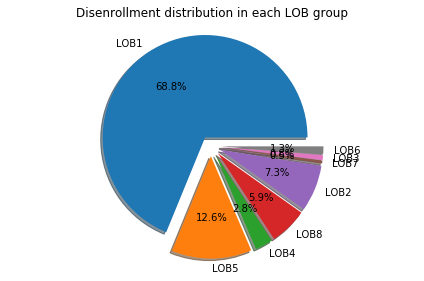

In [12]:
labels = churned.LOB.unique() 
lobcount = churned.groupby('LOB').count()
explode = (0.1, 0.1, 0.1,0.1,0.1,0.1,0.1,0.1)  
plt.pie(lobcount['churned'], labels=labels,shadow=True, explode=explode, autopct='%.1f%%')
plt.axis('equal')
plt.title("Disenrollment distribution in each LOB group")
plt.tight_layout()
plt.show()

68.8% of the disenrollments occur in LOB1 group, followed by LOB5 (12.6% of total disenrollments). This suggests that the LOB group could be a potential churn predictor.

In [36]:
percchurned={}

for lob in labels:
    percchurned[lob]=churned.LOB[df.LOB==lob].count()/df.LOB[df.LOB==lob].count()*100
percchurned

{'LOB1': 29.430830844420306,
 'LOB5': 58.579130986362195,
 'LOB4': 52.64456981664316,
 'LOB8': 50.078003120124805,
 'LOB2': 34.03118991668447,
 'LOB7': 43.87527839643652,
 'LOB3': 51.3493800145879,
 'LOB6': 45.09803921568628}

There is no obvious trend of churn percentage in different LOB groups.

### 2.3 Data cleaning

In [93]:
## Assert that there is no missing value in the target feature:
df.churned.unique()

array([0, 1], dtype=int64)

In [94]:
## Assert that there is no missing value in the hadgap feature:
df['hadGap.'].unique()

array([0, 1], dtype=int64)

In [46]:
## Assert that there is no missing value:
df.isnull().values.any()

True

In [48]:
null_counts = df.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

IPCount    10630
IPCost     10630
EDCount    10630
EDCost     10630
dtype: int64

In [54]:
nulldf=df[df.IPCount.isnull()==True]
nulldf.head(10)

,LOB,churned,Tenure,hadGap.,Age,SDOHScore,conditionScore,substanceScore,physFrailtyScore,mentalFrailtyScore,EDCost,EDCount,IPCost,IPCount,State
6,LOB1,1,30,0,27,0.000003,0.0,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,PA
14,LOB5,1,30,0,41,0.011908,0.0,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,OH
21,LOB4,1,30,0,41,0.165626,0.0,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NC
62,LOB1,1,30,0,45,0.134890,0.0,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,PA
87,LOB4,1,30,0,75,1.078957,0.0,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NC
110,LOB8,1,30,0,75,0.249133,0.0,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,OH
115,LOB2,1,30,0,68,0.019418,0.0,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,PA
132,LOB2,1,29,0,69,0.924359,0.0,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,PA
137,LOB8,1,60,0,57,0.376499,0.0,0.333333,0.0,0.5,NaN,NaN,NaN,NaN,OH
139,LOB5,1,29,0,61,3.887713,0.0,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,OH


In [55]:
nulldf.churned.unique()

array([1], dtype=int64)

In [60]:
countchurned=df.churned[df.churned==1].count()
print('Of all the churned customers, 10630 out of',"{0:}".format(countchurned) ,' have no EDCost, EDcount, IPcost and IP count info. ')

Of all the churned customers, 10630 out of 25206  have no EDCost, EDcount, IPcost and IP count info. 


Without domain knowledge, it is difficult to impuate the data for all these four columns. Afterall, the missing value counts for 40% of the data for these four columns. The manual imputation of such large amount of data may introduce a significant level of inaccuracy and bias. With that in mind, here are several options: <br>

1) remove the rows with missing values in these four columns<br>
2) replace the missing values using mean <br>
3) replace the missing values using median<br>
4) do not use the these four columns for churn prediction<br>

However, if we were to impute the values this time and incorperate them into the model, the model may not generalize well for future data if the future data would have a different distribution pattern than our imputation. Before we decide, let us take a look into the distribution of valid data values in these four columns.

In [75]:
notnullchurn=churned[churned.IPCount.isnull()==False]

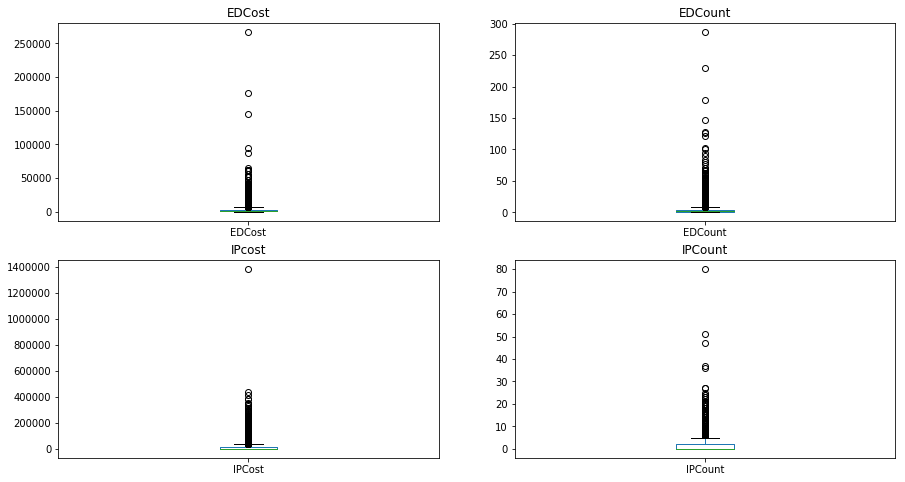

In [76]:
f, axs = plt.subplots(2,2,figsize=(15,8))
plt.subplot(2, 2, 1)
notnullchurn['EDCost'].plot(kind='box', title='EDCost')
plt.subplot(2, 2, 2)
notnullchurn['EDCount'].plot(kind='box', title='EDCount')
plt.subplot(2, 2, 3)
notnullchurn['IPCost'].plot(kind='box', title='IPcost')
plt.subplot(2, 2, 4)
notnullchurn['IPCount'].plot(kind='box', title='IPCount')


plt.show()

In [85]:
notnullchurn[['EDCost','EDCount','IPCost','IPCount']].describe()

,EDCost,EDCount,IPCost,IPCount
count,14576.000000,14576.000000,1.457600e+04,14576.000000
mean,2459.567857,4.064833,1.373702e+04,1.494992
std,4884.345007,6.860320,3.058271e+04,2.681666
min,0.000000,1.000000,0.000000e+00,0.000000
25%,489.685000,1.000000,0.000000e+00,0.000000
50%,1241.615000,2.000000,0.000000e+00,0.000000
75%,2848.370000,4.000000,1.517425e+04,2.000000
max,267123.170000,287.000000,1.381901e+06,80.000000


The above table shows the statistics of the four variables in churned customers. The standard deviation for these 4 variables are very big compared the the means.

In [86]:
df[df.churned==0][['EDCost','EDCount','IPCost','IPCount']].describe()

,EDCost,EDCount,IPCost,IPCount
count,51789.000000,51789.00000,51789.000000,51789.000000
mean,653.945247,1.01929,2157.412596,0.251212
std,1790.942097,2.48898,10199.295645,0.903378
min,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000
75%,579.460000,1.00000,0.000000,0.000000
max,69589.360000,107.00000,844264.290000,21.000000


The above table shows the statistics of the four variables in unchurned customers. Note that the means of the four varibales are much lower for unchurned customers than churned customers. Although these four columns may be good indicators for churn prediction, however, introducing interference on 40% of the entire data is not recommended. For now, we will discard these four columns for our machine learning process. One can always impute the missing value using the means and compare the model performance later.

In [185]:
newdf=df.drop(['EDCost','EDCount','IPCost','IPCount'],axis=1) 

In [88]:
## Assert that there is no missing value:
newdf.isnull().values.any()

False

### 2.3 Outliers

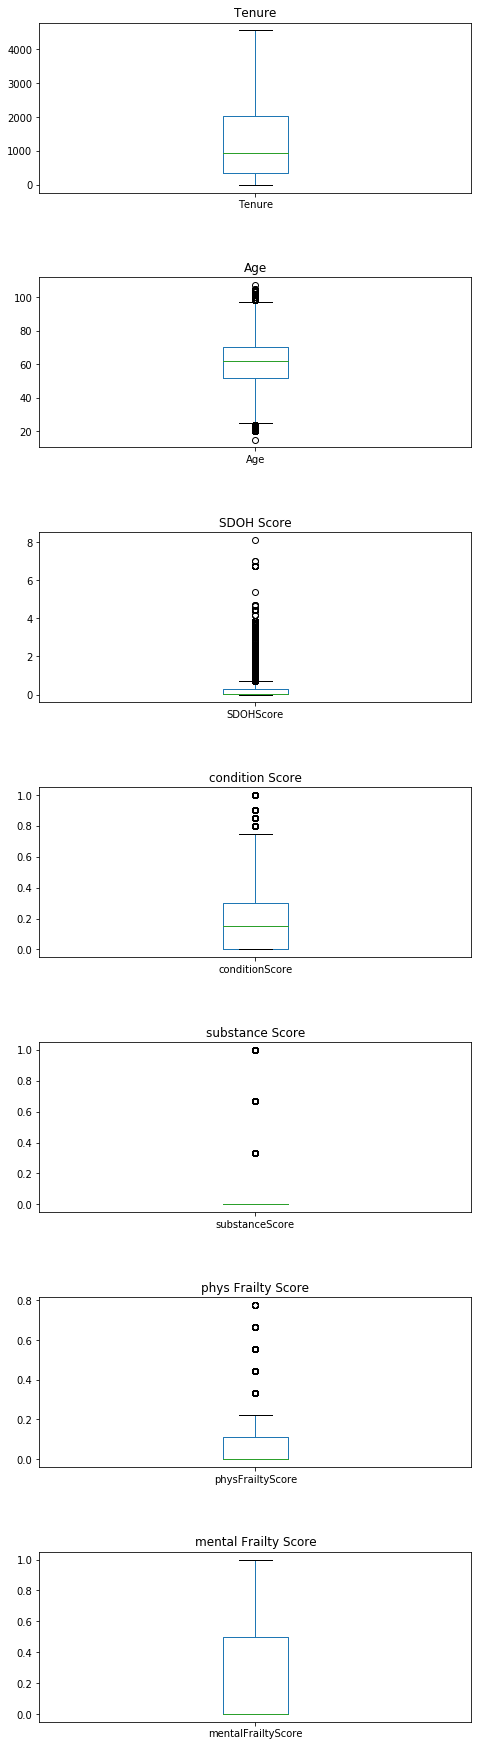

In [149]:

f, axs = plt.subplots(7,1,figsize=(15,8))
plt.subplot(7, 1, 1)
newdf['Tenure'].plot(kind='box', title='Tenure')


plt.subplot(7, 1, 2)
newdf['Age'].plot(kind='box', title='Age')

plt.subplot(7, 1, 3)
newdf['SDOHScore'].plot(kind='box', title='SDOH Score')

plt.subplot(7, 1, 4)
newdf['conditionScore'].plot(kind='box', title='condition Score')

plt.subplot(7, 1, 5)
newdf['substanceScore'].plot(kind='box', title='substance Score')


plt.subplot(7, 1, 6)
newdf['physFrailtyScore'].plot(kind='box', title='phys Frailty Score')

plt.subplot(7, 1, 7)
newdf['mentalFrailtyScore'].plot(kind='box', title='mental Frailty Score')


plt.subplots_adjust(left=0.6, bottom=0.05, right=1, top=3, wspace=0.5, hspace=0.5)
plt.show()

It does not look like there is any input error in the data set. 

In [182]:
## Define a function to remove outliers: the theory is to find data with difference from sample mean bigger than twice
## the standard deviation
def reject_outliers(data,n, m = 3):
    d = np.abs(data[n] - np.median(data[n]))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

In [187]:
trimmeddf=reject_outliers(newdf,'conditionScore', m=3)

trimmeddf.shape

(71687, 11)

In [178]:
newdf.shape

(76995, 11)

Since there are too many suggested outliers in age and SDOH scores, there will be close to 45% data loss if all the outliers in these features are removed, which will result in poor data integrity.
Therefore, only outliers in condition score, physical score and mental scores are removed. After removed outliers in condition score, outliers in the other two features are removed automatically.
And there is minimal data loss in this progress, close to 7% loss.

### 2.4 Data distribution within each feature

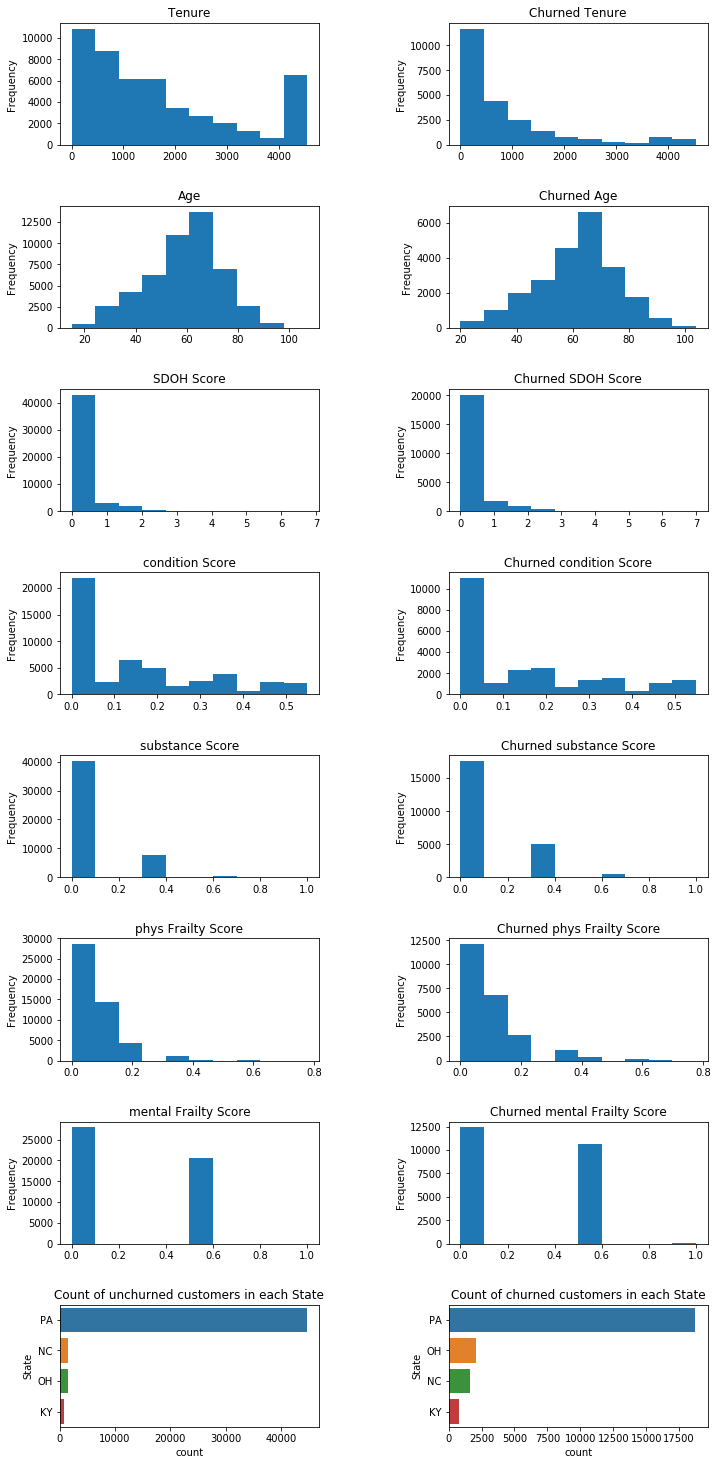

In [188]:
churned=trimmeddf[trimmeddf.churned==1]
unchurned=trimmeddf[trimmeddf.churned==0]
f, axs = plt.subplots(8,2,figsize=(15,10))
plt.subplot(8, 2, 1)
unchurned['Tenure'].plot(kind='hist', title='Tenure')
plt.subplot(8, 2, 2)
churned['Tenure'].plot(kind='hist', title='Churned Tenure')

plt.subplot(8, 2, 3)
unchurned['Age'].plot(kind='hist', title='Age')
plt.subplot(8, 2, 4)
churned['Age'].plot(kind='hist', title='Churned Age')

plt.subplot(8, 2, 5)
unchurned['SDOHScore'].plot(kind='hist', title='SDOH Score')
plt.subplot(8, 2, 6)
churned['SDOHScore'].plot(kind='hist', title='Churned SDOH Score')

plt.subplot(8, 2, 7)
unchurned['conditionScore'].plot(kind='hist', title='condition Score')
plt.subplot(8, 2, 8)
churned['conditionScore'].plot(kind='hist', title='Churned condition Score')

plt.subplot(8, 2, 9)
unchurned['substanceScore'].plot(kind='hist', title='substance Score')
plt.subplot(8, 2, 10)
churned['substanceScore'].plot(kind='hist', title='Churned substance Score')

plt.subplot(8, 2, 11)
unchurned['physFrailtyScore'].plot(kind='hist', title='phys Frailty Score')
plt.subplot(8, 2, 12)
churned['physFrailtyScore'].plot(kind='hist', title='Churned phys Frailty Score')

plt.subplot(8, 2, 13)
unchurned['mentalFrailtyScore'].plot(kind='hist', title='mental Frailty Score')
plt.subplot(8, 2, 14)
churned['mentalFrailtyScore'].plot(kind='hist', title='Churned mental Frailty Score')

plt.subplot(8, 2, 15)
sns.countplot(y="State",data=unchurned)
plt.title('Count of unchurned customers in each State')
plt.subplot(8, 2, 16)
sns.countplot(y="State",data=churned)
plt.title('Count of churned customers in each State')

plt.subplots_adjust(left=0.4, bottom=0.05, right=1, top=2, wspace=0.5, hspace=0.5)
plt.show()

Based on the above plots, there is no apparent difference in the distribution of value in each data variable between churned and unchurned customers, except for tenure.

### 2.5 Colinearity within the features

In [190]:
trimmeddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71687 entries, 0 to 76994
Data columns (total 11 columns):
LOB                   71687 non-null object
churned               71687 non-null int64
Tenure                71687 non-null int64
hadGap.               71687 non-null int64
Age                   71687 non-null int64
SDOHScore             71687 non-null float64
conditionScore        71687 non-null float64
substanceScore        71687 non-null float64
physFrailtyScore      71687 non-null float64
mentalFrailtyScore    71687 non-null float64
State                 71687 non-null object
dtypes: float64(5), int64(4), object(2)
memory usage: 6.6+ MB


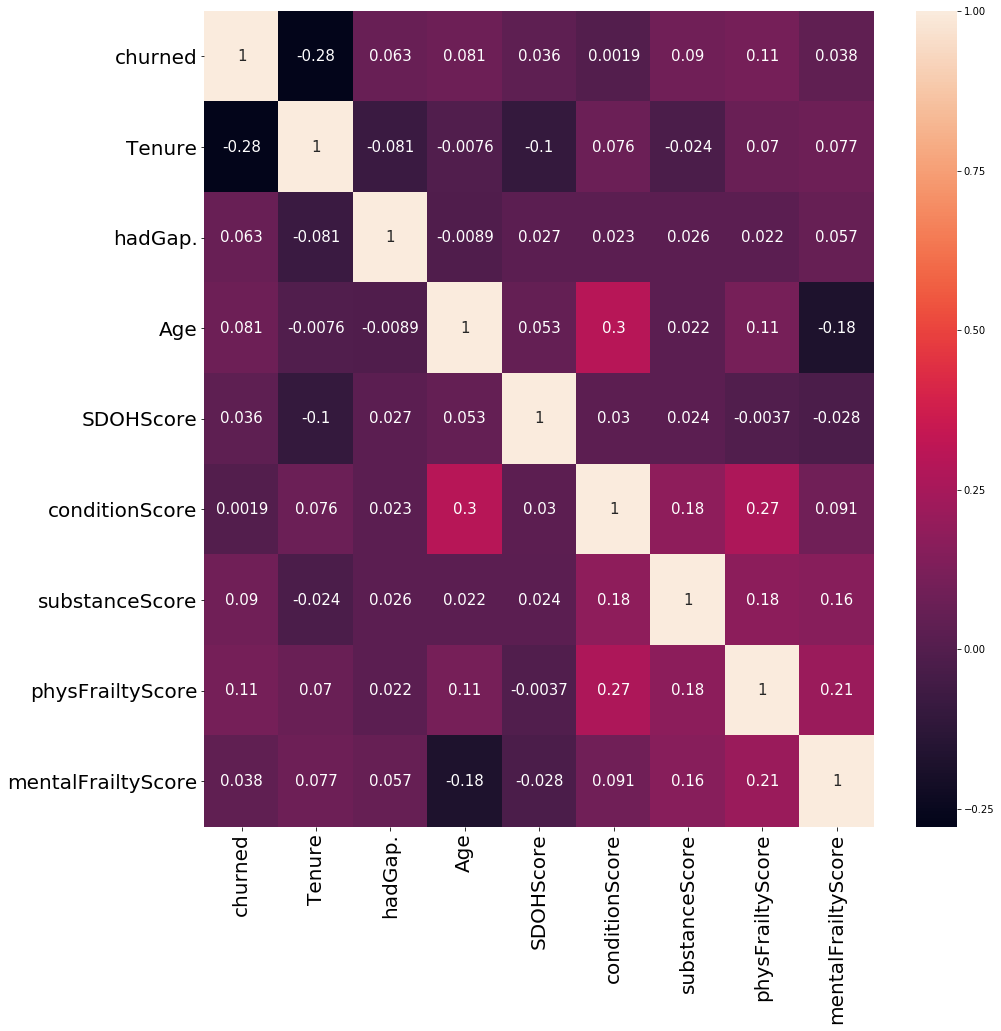

In [197]:
coef = trimmeddf.corr()
sns.heatmap(coef, xticklabels=coef.columns.values, yticklabels=coef.columns.values, annot = True, annot_kws={'size':15})
heat_map=plt.gcf()
heat_map.set_size_inches(15,15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

There are several week colinearities among the features: condition score vs age, consition score vs phys frailty score. However, these colinearities are week, therefore, no feature will be removed at this point.

## 3.0 Machine Learning.

In [264]:
x = pd.get_dummies(trimmeddf, drop_first=True) #Drop first dummy column, since it is correlated to the others
x=x.drop(['churned'], axis=1)
y = trimmeddf['churned'].values

In [265]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=10, stratify=y)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
score_func = make_scorer(roc_auc_score, greater_is_better=True)

In [266]:
#Setup the RF object
rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1)

#Hyperparameter grid
param_grid = {'n_estimators' : [50, 60, 70,80], 'min_samples_split' : [2, 3, 4,5], 
              'max_depth' : [10,15,20,25]}

#Setup the Gridsearch
rf_cv = GridSearchCV(rf, param_grid, cv=cv, scoring=score_func, verbose=1)

#Fit the data
rf_cv.fit(x_train, y_train)

#Print out the best model
print('Best RF Params: {}'.format(rf_cv.best_params_))
print('Best RF Score : %f' % rf_cv.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  5.2min finished


Best RF Params: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 80}
Best RF Score : 0.718046


In [267]:
rf_best = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1, 
                                 n_estimators=rf_cv.best_params_['n_estimators'],
                                 min_samples_split=rf_cv.best_params_['min_samples_split'], 
                                 max_depth=rf_cv.best_params_['max_depth'], random_state=12)

rf_best.fit(x_train, y_train)

#Print the score/metric for the input model which must be fit
def get_scores(model, name='unk', score=roc_auc_score):
    
    #Make prediction for the model
    pred = model.predict(x_test)
    pred_prob = model.predict_proba(x_test)[:,1]
    

    #Calculate the score on the entire test set
    auc = score(y_test, pred_prob)
    
    #Calculate the score on CV test set
    cv_scores = cross_val_score(model, x_test, y_test, cv=cv, scoring=score_func)
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    
    #Save to dataframe to be used for printing only
    model_score = pd.DataFrame(columns=['Model', 'Test score', 'CV score'])
    model_score.loc[0] = [name, auc, mean_cv]
    model_score.set_index('Model', inplace=True)
    print(model_score)

In [268]:
get_scores(rf_best, 'RF')

       Test score  CV score
Model                      
RF       0.804323  0.697316


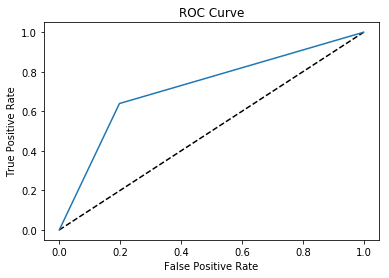

The ROC score for the randomforest model is 0.7209  


In [279]:
# Generate ROC curve values: fpr, tpr, thresholds
y_pred = rf_best.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test,y_pred)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print( 'The ROC score for the randomforest model is {0:.4f}  '.format(roc_auc_score(y_test, y_pred)))

In [270]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
   
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances by RandomForest Classifier')
    plt.show()
    
    return df

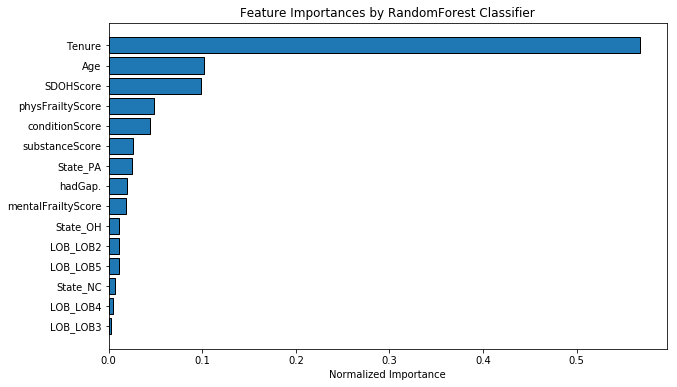

In [271]:
importance = rf_best.feature_importances_
feature = x.columns
fi = pd.DataFrame()
fi['importance'] = importance
fi['feature'] = feature
fi_sorted = plot_feature_importances(fi)

Confusion matrix, without normalization
[[7785 1917]
 [1672 2964]]
The confusion matrix for the randomforest model is listed below:


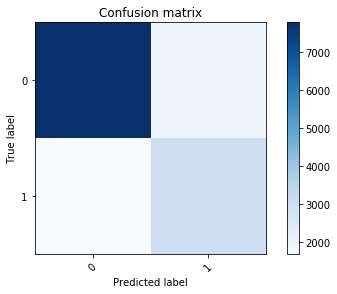

In [299]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0','1'], rotation=45)
    plt.yticks(tick_marks,  ['0','1'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
print('The confusion matrix for the randomforest model is listed below:')

TN=7785, FP= 1917, FN= 1672, TP= 2964 <br>
precision = 61%
recall= 64%

In [319]:
unchurned=trimmeddf[trimmeddf.churned==0]
unchurnedx=unchurned.drop('churned', axis=1)
unchurnedx=pd.get_dummies(unchurnedx,drop_first=True)

In [320]:
probs= rf_best.predict_proba(unchurnedx)[:,1] ## extract the churn probability

In [321]:
score=[]
for prob in probs:
    x=0
    if prob>0 and prob<0.2:
        x=1
    elif prob>=0.2 and prob<0.4:
        x=2
    elif prob>=0.4 and prob<0.6:
        x=3
    elif prob>=0.6 and prob<0.8:
        x=4
    elif prob>=0.8:
        x=5
    score.append(x)

In [323]:
final_unchurned=unchurned.assign(Churn_risk_score=score)

In [325]:
final_unchurned.head()

,LOB,churned,Tenure,hadGap.,Age,SDOHScore,conditionScore,substanceScore,physFrailtyScore,mentalFrailtyScore,State,Churn_risk_score
0,LOB2,0,49,0,59,0.018738,0.0,0.0,0.0,0.0,PA,2
1,LOB1,0,49,0,80,0.012270,0.0,0.0,0.0,0.0,PA,3
2,LOB1,0,49,0,45,0.000435,0.0,0.0,0.0,0.0,PA,3
3,LOB4,0,49,0,25,0.033174,0.0,0.0,0.0,0.0,NC,2
4,LOB5,0,49,0,66,0.405166,0.0,0.0,0.0,0.0,OH,4


The existing customers are divided into 5 groups, each with a different risk score: 1 corresponds to minimal risk of disenrollment, 2 corresponds to low risk of disenrollment, 3 corresponds to medium risk of disenrollment, 4  corresponds to high risk of disenrollment and 5 corresponds to very high risk of disenrollment in the future.

Using this index, the insurance company can make different startegies that focus on different risk groups: for example: sending out surveys to high risk group to understand customer behavior and opitions about the insurance in order to improve their experience and retention rate. Other strategies can include lower the insurance premium, co-pay, deductible, investing in marketing for mid age to senior group (age of 40 to 80).

## 4.0 Further discussion

There are several in-depth analysis we could do to potentially improve the model performance:
1) Instead of removing the four variables: EDCost,EDCount,IPCost,IPCount, we could impute the missing data using mean or median values from each variables for machine learning.

2) Instead of using State and LOB groups as independent variables, one can do individual prediction under each category. For example, separate customers from PA and do an individual prediction.

3) Instead of removing the four variables: EDCost,EDCount,IPCost,IPCount, we could remove the rows with missing values in these four columns. Although losing data, the added four columns could be important features for churn prediction.

4) Evaluate other ML algorithms such as SVM or KNN and compare the performances.

5) Feature engineering, which needs domain knowledge: creating new feature(s) using a combination of existing features.